
Ноутбук посвящен исследованию применения transformer-моделей (RuBERT и MathBERT) для классификации математических задач (многоклассовой классификации) по темам с детальным анализом различных стратегий fine-tuning.

Код тестирует различные комбинации RuBERT и MathBERT с наличием/отсуствием заморозки, предобработки, языка (ru/en)

В качестве датасета использован датасет математических задач по разным темам.
[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import gc
import copy
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM
from typing import Union



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df_raw= pd.read_excel('/kaggle/input/tasks-problems-ru/data_problems.xlsx')

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5273 non-null   int64 
 1   Задача      5273 non-null   object
 2   Тема        5273 non-null   object
dtypes: int64(1), object(2)
memory usage: 123.7+ KB


In [ ]:
df_raw.head(8)

,Unnamed: 0,Задача,Тема
0,0,Между девятью планетами Солнечной системы введ...,Графы
1,1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы
2,2,"В государстве 100 городов, и из каждого из них...",Графы
3,3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы
4,4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы
5,0,"В стране Семёрка 15 городов, каждый из которых...",Графы
6,1,"Имеется группа островов, соединённых мостами т...",Графы
7,2,"Докажите, что не существует графа без петель и...",Графы


In [ ]:
df = df_raw.drop(columns=['Unnamed: 0'])

In [ ]:
df.sample(8)

,Задача,Тема
860,"Существуют ли числа такие p и q, что уравнения...",Многочлен
3368,p и 8p2 + 1 – простые числа. Найдите p.,Теория чисел
2572,"Докажите, что уравнение l² + m² = n² + 3 име...",Теория чисел
2717,в),Теория чисел
4878,"Имеется 19 гирек весов 1, 2, 3, ..., 19 г: дев...",Дирихле
627,"Дана фиксированная хорда MN окружности, не явл...",Геометрия
1481,"Сколько последовательностей {a1, a2, ..., a2n...",Комбинаторика
2214,Доказать: сумма \r\n а) любого количества чё...,Теория чисел


In [ ]:
df['Тема'].value_counts()

Тема
Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: count, dtype: int64

In [ ]:
total_duplicates = df[df.duplicated(subset='Задача')]
total_duplicates.groupby('Тема').size()

Тема
Геометрия          1
Дирихле          180
Инвариант        116
Комбинаторика    378
Многочлен          4
Теория чисел     244
dtype: int64

In [ ]:
total_duplicates

,Задача,Тема
694,,Геометрия
831,,Многочлен
913,"Рассмотрим графики функций y = x² + px + q, ...",Многочлен
1033,Из полного 100-вершинного графа выкинули 98 рё...,Многочлен
1047,Собралось n человек. Некоторые из них знакомы ...,Многочлен
...,...,...
5259,"В стране 1001 город, каждые два города соедине...",Дирихле
5260,"В таблицу 2006×2006 вписаны числа 1, 2, 3, ......",Дирихле
5263,В квадрат вписано 1993 различных правильных тр...,Дирихле
5265,"Каждая деталь конструктора ""Юный паяльщик"" – э...",Дирихле


In [ ]:
df=df.drop_duplicates('Задача',ignore_index=True)

In [ ]:
df

,Задача,Тема
0,Между девятью планетами Солнечной системы введ...,Графы
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы
2,"В государстве 100 городов, и из каждого из них...",Графы
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы
...,...,...
4345,Остроугольный треугольник разрезали прямолиней...,Дирихле
4346,Дьявол предлагает Человеку сыграть в следующую...,Дирихле
4347,По шоссе в одном направлении едут 10 автомобил...,Дирихле
4348,В пространстве имеются 30 ненулевых векторов. ...,Дирихле


In [ ]:
df['Длина_текста'] = df['Задача'].apply(lambda x: len(str(x)))

In [ ]:
df

,Задача,Тема,Длина_текста
0,Между девятью планетами Солнечной системы введ...,Графы,316
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы,284
2,"В государстве 100 городов, и из каждого из них...",Графы,99
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы,123
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы,256
...,...,...,...
4345,Остроугольный треугольник разрезали прямолиней...,Дирихле,384
4346,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,392
4347,По шоссе в одном направлении едут 10 автомобил...,Дирихле,535
4348,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,116


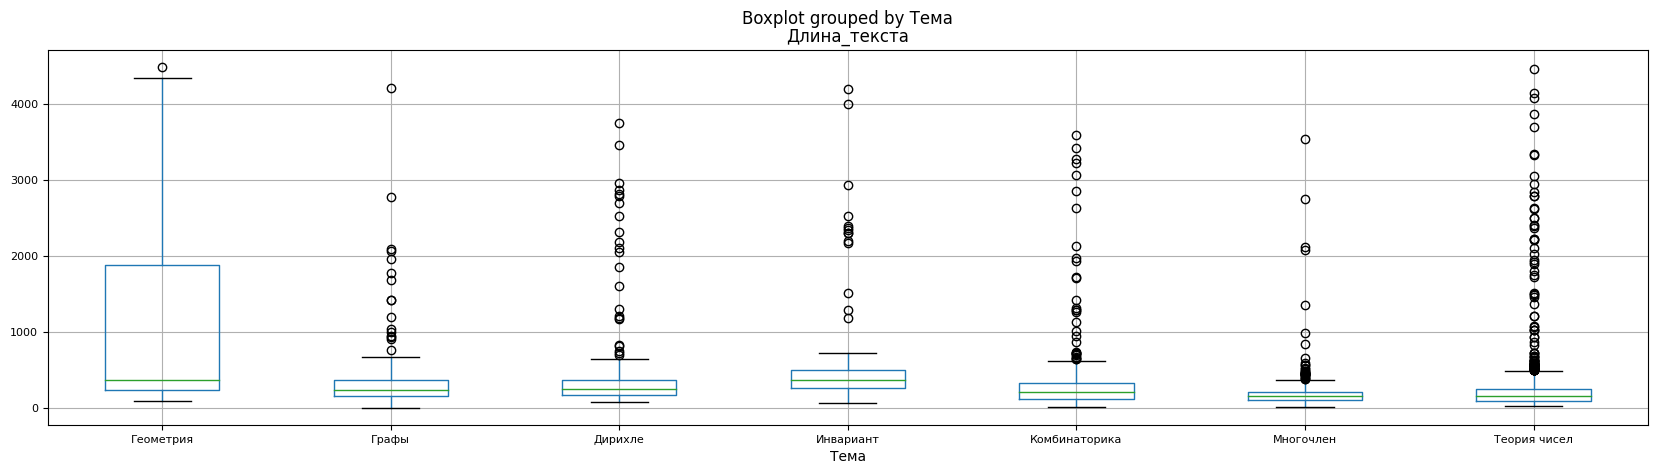

In [ ]:
df.boxplot(
    column=["Длина_текста"], by="Тема", fontsize=8, figsize=(20, 5)
);

По категории "геометрия" количество символов в задачах,находящееся в 3,4 квартилях, значительно выше, чем по другим категориям. В целом присуствует множество выбросов по всем категориям

In [ ]:
df.nlargest(5, 'Длина_текста')
# df.nsmallest(50, 'Длина_текста')

,Задача,Тема,Длина_текста
511,\nНа гипотенузе AB прямоугольного треугольника...,Геометрия,4489
3945,а) Скупой рыцарь хранит золотые монеты в ше...,Теория чисел,4453
512,\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\t\tПрислать к...,Геометрия,4335
526,\nНа продолжении хорды KL окружности с центром...,Геометрия,4311
295,"На олимпиаду пришло 2018 участников, некоторые...",Графы,4204


In [ ]:
 df.loc[511 ,'Задача']

'\nНа гипотенузе AB прямоугольного треугольника ABC во внешнюю\nсторону построен квадрат с центром в точке O. Докажите, что \nCO — биссектриса прямого угла.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\t\tПрислать комментарий\n\t\t\t\t\n\n\n\n\t\t\t\xa0\xa0\xa0\n\t\t\t\n\t\t\t\tРешение\n\t\t\t\n\n\n\n\n\n\n\n\n\n\n\t\t\t\t\tЗадача\n\t\t\t\t\t\n\t\t\t\t\t\t64345\n\n\n\n\n\n\n\n\t\t\t\t\t\tТемы:\n\t\t\t\t\t\t\xa0\n\t\t\t\t\t\n\n\t\t\t\t\t\t[\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tВписанные и описанные окружности\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t]\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t[\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tОртоцентр и ортотреугольник\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t]\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t[\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tДве касательные, проведенные из одной точки\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t]\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t[\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tЧетыре точки, лежащие на одной окружности\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t]\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t[\n\t\t\

Очистим записи от символов, появившихся при некорректном парсинге данных, а также те, которые короче 40 символов

In [ ]:
df['Задача'] = df['Задача'].apply(lambda x:  re.sub(r'[\n\t]+|Прислать комментарий+|Решение', ' ', x)   )

In [ ]:
df.loc[511 ,'Задача']

' На гипотенузе AB прямоугольного треугольника ABC во внешнюю сторону построен квадрат с центром в точке O. Докажите, что  CO — биссектриса прямого угла.   \xa0\xa0\xa0   Задача 64345 Темы: \xa0 [ Вписанные и описанные окружности ] [ Ортоцентр и ортотреугольник ] [ Две касательные, проведенные из одной точки ] [ Четыре точки, лежащие на одной окружности ] [ Углы, опирающиеся на равные дуги и равные хорды ] [ Угол между касательной и хордой ] Сложность: 4-Классы: 9,10 Автор: Кожевников П.А. Остроугольный треугольник ABC вписан в окружность Ω. Касательные, \r проведённые к Ω в точках B и C, пересекаются в точке P. \r Точки D и E – основания перпендикуляров, опущенных из точки P на прямые AB и AC. Докажите, что точка пересечения высот треугольника ADE является серединой отрезка BC.   \xa0\xa0\xa0   Задача 65203 Темы: \xa0 [ Признаки и свойства равнобедренного треугольника. ] [ Признаки и свойства параллелограмма ] [ Вписанные и описанные окружности ] [ Четыре точки, лежащие на одной окруж

In [ ]:
df = df[df['Длина_текста'] > 40]

/tmp/ipykernel_34/1717810502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Длина_текста'] = df['Задача'].apply(lambda x: len(str(x)))


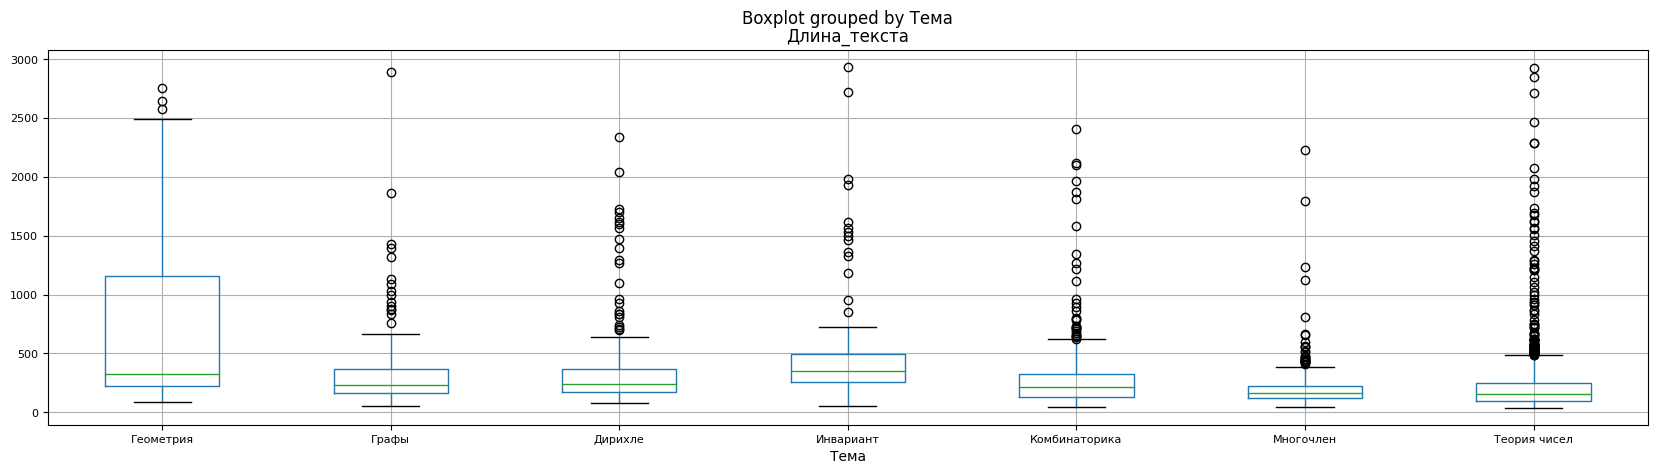

In [ ]:
df['Длина_текста'] = df['Задача'].apply(lambda x: len(str(x)))

df.boxplot(column=["Длина_текста"], by="Тема", fontsize=8, figsize=(20, 5));

In [ ]:
df

,Задача,Тема,Длина_текста
0,Между девятью планетами Солнечной системы введ...,Графы,316
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы,284
2,"В государстве 100 городов, и из каждого из них...",Графы,99
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы,123
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы,256
...,...,...,...
4345,Остроугольный треугольник разрезали прямолиней...,Дирихле,384
4346,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,392
4347,По шоссе в одном направлении едут 10 автомобил...,Дирихле,535
4348,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,116


Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
"""кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone модель huggingface
Т.е. конструктор класса принимает на вход название модели и подгружает её из huggingface, а затем использует в качестве backbone

"""
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super(TransformerClassificationModel, self).__init__()

        if isinstance(base_transformer_model, str): # Проверка, является ли base_transformer_model строкой
            self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model) # Инициализация токенизатора

           # Загрузка backbone модели из HuggingFace
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        else:
            self.tokenizer = None
            self.backbone = base_transformer_model

        # размер скрытых состояний (выходных признаков) основной модели
        self.output_features = self.backbone.config.hidden_size

        # Классификационная голова
        self.classifier1 = nn.Linear(self.output_features, self.output_features // 2)
        self.non_linear = nn.Tanh()
        self.classifier2 = nn.Linear(self.output_features // 2, num_classes) # Выход - Логиты для 7 классов математических тем

    # input_ids-идентификаторы токенов,  и attention_mask- маска внимания
    def forward(self, input_ids, attention_mask=None):
        # Проверка, был ли загружен токенизатор для модели
        if self.tokenizer is not None:
          # Пропускает входные данные через модель трансформера для получения выходных данных
            outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        else:
            outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = outputs.pooler_output  # Извлечение выходного представления последнего слоя(pooler_output),
        # которое будет использовано для классификации
        logits = self.classifier1(pooled_output)
        logits = self.classifier2(self.non_linear(logits))

        return (logits, pooled_output)

In [ ]:
model=TransformerClassificationModel('cointegrated/rubert-tiny2', num_classes=7)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [ ]:
model

TransformerClassificationModel(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e

In [ ]:
# функция заморозки backbone у модели
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

In [ ]:
model_0 = freeze_backbone_function(model)

In [ ]:
import copy

'''
Функция для тренировки (дообучения) трансформера (TransformerClassificationModel)
с поддержкой обучения с замороженным и размороженным backbone.
'''

# train_loader: загрузчик данных для обучения
# eval_loader: загрузчик данных для оценки модели
def train_transformer(transformer_model,  train_loader, eval_loader, freeze_backbone=True, num_epochs=3):
    model = copy.copy(transformer_model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    if freeze_backbone:
        model = freeze_backbone_function(model) # Замораживаем параметры backbone

    loss_epochs = {'eval' : [], 'train' : []}

    for epoch in tqdm(range(num_epochs)):
      # перевод модели в режим обучения train
        model.train()
        train_loss = 0
        for (i, batch) in enumerate(train_loader):

           # Обнуление градиентов
            optimizer.zero_grad()

            # Получение выходных данных модели (logit) путем передачи пакета данных через модель и извлечения предсказаний (логитов)
            logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]

            loss = criterion(logit, batch['label'].long().to(device))
            train_loss += loss.item()
            # вычисление градиентов функции потерь по параметрам модели.
            loss.backward()

            # Обновление параметров модели на основе вычисленных градиентов
            optimizer.step()

        # оценка модели на валидационном датасете
        if (epoch % 2) == 0:

          # Модель переводится в режим оценки (eval)
            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for (i, batch) in enumerate(eval_loader):
                    logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]
                    loss = criterion(logit, batch['label'].long().to(device))
                    eval_loss += loss.item()
            print("epoch :", epoch, "loss train:", train_loss/len(train_loader), "eval loss:", eval_loss/len(eval_loader))

            # для каждой парной эпохи
            loss_epochs['eval'].append(eval_loss/len(eval_loader))
            loss_epochs['train'].append(train_loss/len(train_loader))
        torch.cuda.empty_cache()

        # сборка мусора для освобождения ресурсов после каждой эпохи
        gc.collect()

    return (model, loss_epochs)

In [ ]:
'''
дообучение cointegrated/rubert-tiny2 из huggingface
'''

name="cointegrated/rubert-tiny2"
tokenizer_rubert = AutoTokenizer.from_pretrained(name)

In [ ]:
def df_preprocess(make_simple_preprocess=False, translate_to_en=False):
    global df
    df1=df.copy()
    if make_simple_preprocess:

        dataset = pd.read_excel('/kaggle/input/tasks-problems-ru/data_problems.xlsx')
        df1 = dataset.drop(columns=['Unnamed: 0'])
        df1 = df1.drop_duplicates('Задача', ignore_index=True)
        df1['Длина_текста'] = df1['Задача'].apply(lambda x: len(str(x)))
        df1['Задача'] = df1['Задача'].apply(lambda x: re.sub(r'[\n\t]+|Прислать комментарий+|Решение', ' ', x))
        df1 = df1[df1['Длина_текста'] > 40]
        label_encoder = LabelEncoder()
        df1['Тема'] = label_encoder.fit_transform(df1['Тема'])
    else:
        dataset = pd.read_excel('/kaggle/input/tasks-problems-ru/data_problems.xlsx')
        df1 = dataset.drop(columns=['Unnamed: 0'])
        label_encoder = LabelEncoder()
        df1['Тема'] = label_encoder.fit_transform(df1['Тема'])

    if translate_to_en:
        df1 = pd.read_excel('/kaggle/input/math-translation/math_translation.xlsx')
    return df1

    '''
        код для перевода на английский, закомментирован и выгружен в датасет для экономии времени

        tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
        model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

        def translate_to_eng(text):
            input_ids = tokenizer.encode(text, return_tensors="pt")
            output_ids = model.generate(input_ids, max_new_tokens=200, max_length=512)
            translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            return translated_text

        tqdm.pandas(desc="Перевод задач")
        df1['Переведенная_задача'] = df1['Задача'].progress_apply(translate_to_eng)

        df1.to_csv('/kaggle/working/ENtranslated_preprosessed_df.csv', index=False)
    '''

In [ ]:
df1=df_preprocess(make_simple_preprocess = True, translate_to_en = False)

In [ ]:
df1

,Задача,Тема,Длина_текста
0,Между девятью планетами Солнечной системы введ...,1,316
1,"В стране Цифра есть 9 городов с названиями 1, ...",1,284
2,"В государстве 100 городов, и из каждого из них...",1,99
3,"В классе 30 человек. Может ли быть так, что 9 ...",1,123
4,В городе Маленьком 15 телефонов. Можно ли их с...,1,256
...,...,...,...
4345,Остроугольный треугольник разрезали прямолиней...,2,384
4346,Дьявол предлагает Человеку сыграть в следующую...,2,392
4347,По шоссе в одном направлении едут 10 автомобил...,2,535
4348,В пространстве имеются 30 ненулевых векторов. ...,2,116


In [ ]:
#labels = np.array(df1['Тема'])

def translation(df1):
    # замена имен классов на их соответствующие индексы
    name_index = {name : i for (i, name) in enumerate(set(df1['Тема']))}
    df1['Тема'] = [name_index[name] for name in df1['Тема']]
    # получаем массив меток
    labels = np.array(df1['Тема'])
    # список текстов для каждой задачи

    texts = df1['Задача'].tolist()

    return (texts, labels)

In [ ]:
'''
Обработка данных и создание DataLoader
Процесс токенизации:
  -Ограничение длины до 256 токенов
  -Добавление специальных токенов ([CLS], [SEP])
  -Создание масок внимания
'''
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    # получение текста и метки по индексу
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # токенизирование текста с использованием токенизатора
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True)

        # словарь с данными: текстом, input_ids, маской внимания и меткой
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)}

In [ ]:
def final_dataset(df1, tokenizer):
    train_df , eval_df = train_test_split(df1, test_size=0.2, shuffle=True)
    #  словарь, сопоставляющий имена классов с их индексами
    name_index = {name : i for (i, name) in enumerate(set(df1['Тема']))}
    # общее количество уникальных классов
    number_classes = len(name_index)

    train_data = translation(train_df)
    eval_data = translation(eval_df)

    train_dataset = MyDataset(train_data[0], train_data[1], tokenizer)
    eval_dataset = MyDataset(eval_data[0], eval_data[1], tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    eval_loader  = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    return train_loader, eval_loader

с заморозкой и предобработкой

In [ ]:
df1=df_preprocess(make_simple_preprocess = True, translate_to_en = False)

name="cointegrated/rubert-tiny2"
tokenizer_rubert = AutoTokenizer.from_pretrained(name)
rubert= TransformerClassificationModel(AutoModel.from_pretrained(name, output_attentions=True), 7).to(device)

train_loader, eval_loader=final_dataset(df1, tokenizer_rubert)

rubert_freezed,losses = train_transformer(rubert,
                                           train_loader,eval_loader,
                                           freeze_backbone=True,
                                           num_epochs=12)

  8%|▊         | 1/12 [00:07<01:26,  7.90s/it]

epoch : 0 loss train: 1.8933653983305085 eval loss: 1.8492827347989351


 25%|██▌       | 3/12 [00:19<00:57,  6.42s/it]

epoch : 2 loss train: 1.7117998864290849 eval loss: 1.690742238512579


 42%|████▏     | 5/12 [00:31<00:43,  6.18s/it]

epoch : 4 loss train: 1.5789327329059817 eval loss: 1.5824107943840746


 58%|█████▊    | 7/12 [00:43<00:30,  6.07s/it]

epoch : 6 loss train: 1.4988102097556275 eval loss: 1.523038092649208


 75%|███████▌  | 9/12 [00:55<00:18,  6.04s/it]

epoch : 8 loss train: 1.4496669451583106 eval loss: 1.4853117353511307


 92%|█████████▏| 11/12 [01:07<00:06,  6.04s/it]

epoch : 10 loss train: 1.410697485478419 eval loss: 1.4552374324708615


100%|██████████| 12/12 [01:12<00:00,  6.03s/it]


In [ ]:
def calc_loss_graph(losses, name):
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['eval'], label='eval')
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['train'], label='train')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(name)
    plt.legend()
    plt.show()

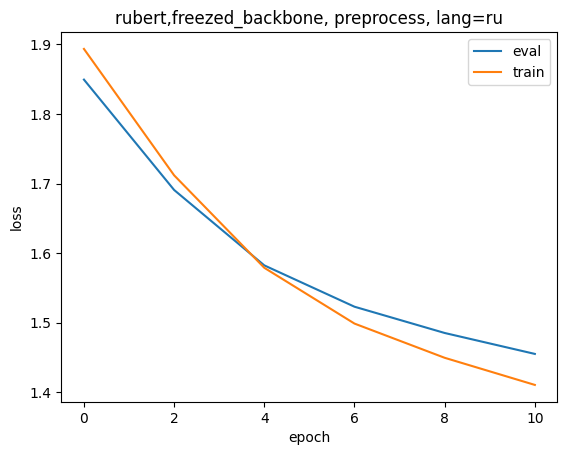

In [ ]:
calc_loss_graph(losses, 'rubert,freezed_backbone, preprocess, lang=ru')

с заморозкой без предобработки

In [ ]:
df1=df_preprocess(make_simple_preprocess = False, translate_to_en = False)

train_loader, eval_loader=final_dataset(df1, tokenizer_rubert)

rubert_freezed_no_preproc,losses1 = train_transformer(rubert,
                                                      train_loader,eval_loader,
                                                      freeze_backbone=True,
                                                      num_epochs=12)

  8%|▊         | 1/12 [00:08<01:29,  8.17s/it]

epoch : 0 loss train: 1.488662194573518 eval loss: 1.4738309419516362


 25%|██▌       | 3/12 [00:23<01:09,  7.68s/it]

epoch : 2 loss train: 1.454373575747013 eval loss: 1.4431052515001008


 42%|████▏     | 5/12 [00:37<00:53,  7.59s/it]

epoch : 4 loss train: 1.42748754539273 eval loss: 1.4170986883568042


 58%|█████▊    | 7/12 [00:52<00:37,  7.54s/it]

epoch : 6 loss train: 1.4018574072556063 eval loss: 1.3936887004158713


 75%|███████▌  | 9/12 [01:07<00:22,  7.51s/it]

epoch : 8 loss train: 1.3814550710446907 eval loss: 1.3729819962472627


 92%|█████████▏| 11/12 [01:22<00:07,  7.53s/it]

epoch : 10 loss train: 1.357469883380514 eval loss: 1.3541493542266614


100%|██████████| 12/12 [01:28<00:00,  7.41s/it]


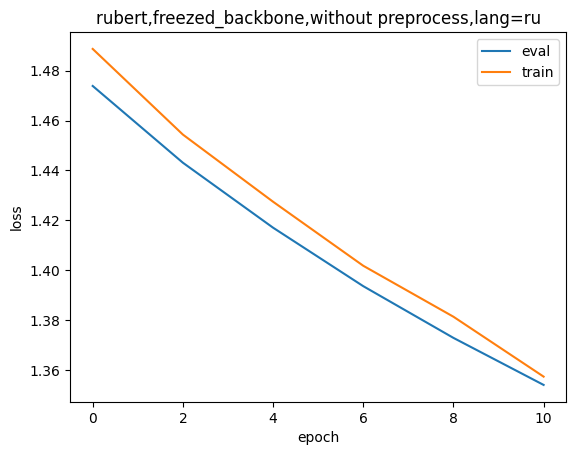

In [ ]:
calc_loss_graph(losses1, 'rubert,freezed_backbone,without preprocess,lang=ru')

Без заморозки с предобработкой

In [ ]:
df1=df_preprocess(make_simple_preprocess = True, translate_to_en = False)

train_loader, eval_loader=final_dataset(df1, tokenizer_rubert)

rubert_full_finetuned_prepr,losses2 = train_transformer(rubert,
                                                        train_loader,eval_loader,
                                                        freeze_backbone=False,
                                                        num_epochs=12)

  8%|▊         | 1/12 [00:06<01:13,  6.71s/it]

epoch : 0 loss train: 1.2436813130131308 eval loss: 1.242521752726357


 25%|██▌       | 3/12 [00:18<00:56,  6.32s/it]

epoch : 2 loss train: 1.2243896427581895 eval loss: 1.2221304987961392


 42%|████▏     | 5/12 [00:31<00:43,  6.22s/it]

epoch : 4 loss train: 1.205619954275635 eval loss: 1.2048727926218286


 58%|█████▊    | 7/12 [00:43<00:30,  6.17s/it]

epoch : 6 loss train: 1.1916929666163787 eval loss: 1.1892902131350536


 75%|███████▌  | 9/12 [00:55<00:18,  6.14s/it]

epoch : 8 loss train: 1.1799890626713914 eval loss: 1.1754774484994277


 92%|█████████▏| 11/12 [01:07<00:06,  6.12s/it]

epoch : 10 loss train: 1.166473336377234 eval loss: 1.162885993156793


100%|██████████| 12/12 [01:12<00:00,  6.04s/it]


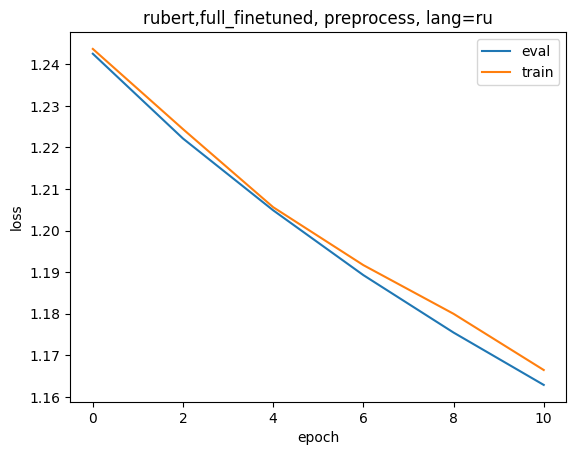

In [ ]:
calc_loss_graph(losses2, 'rubert,full_finetuned, preprocess, lang=ru')

In [ ]:
'''
Обучение tbs17/MathBert (с замороженным backbone и без заморозки)
'''



'''
с заморозкой, с предобработкой, русский язык
'''
df1=df_preprocess(make_simple_preprocess = True, translate_to_en = False)
name="tbs17/MathBert"
tokenizer_mathBert = AutoTokenizer.from_pretrained(name)
mathBert = TransformerClassificationModel(AutoModel.from_pretrained(name, output_attentions=True), 7).to(device)

train_loader, eval_loader=final_dataset(df1, tokenizer_mathBert)

mathBert_freezed_backbone_ru,losses3 = train_transformer(mathBert,
                                                         train_loader,eval_loader,
                                                        freeze_backbone=True,
                                                        num_epochs=12)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
  8%|▊         | 1/12 [01:03<11:37, 63.44s/it]

epoch : 0 loss train: 1.5923720494193851 eval loss: 1.542744645532572


 17%|█▋        | 2/12 [01:54<09:20, 56.02s/it]

epoch : 2 loss train: 1.5284411041241772 eval loss: 1.5191810131072998


 42%|████▏     | 5/12 [04:52<06:50, 58.70s/it]

epoch : 4 loss train: 1.5089627687098845 eval loss: 1.505210573943156


 58%|█████▊    | 7/12 [06:46<04:52, 58.46s/it]

epoch : 6 loss train: 1.496610643728724 eval loss: 1.481567751686528


 75%|███████▌  | 9/12 [08:40<02:55, 58.40s/it]

epoch : 8 loss train: 1.4825445975897447 eval loss: 1.4677591886160508


 92%|█████████▏| 11/12 [10:35<00:58, 58.34s/it]

epoch : 10 loss train: 1.4703840250676532 eval loss: 1.4525341222871024


100%|██████████| 12/12 [11:26<00:00, 57.20s/it]


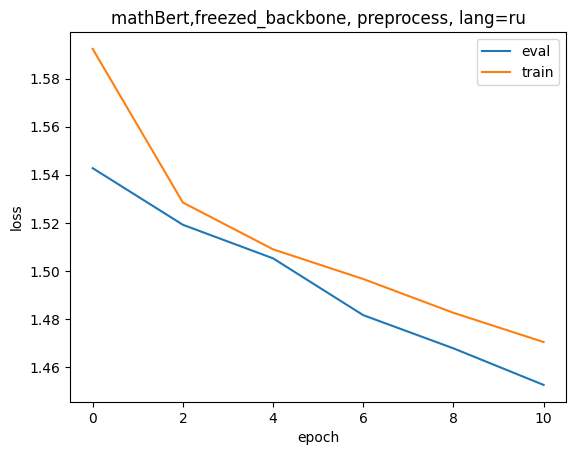

In [ ]:
calc_loss_graph(losses3, 'mathBert,freezed_backbone, preprocess, lang=ru')

In [ ]:
'''
без заморозки, с предобработкой, русский язык
'''

df1=df_preprocess(make_simple_preprocess = True, translate_to_en = False)

train_loader, eval_loader=final_dataset(df1, tokenizer_mathBert)

mathBert_full_finetuned,losses4 = train_transformer(mathBert,
                                                    train_loader,eval_loader,
                                                    freeze_backbone=False,
                                                    num_epochs=12)

  8%|▊         | 1/12 [01:03<11:38, 63.46s/it]

epoch : 0 loss train: 1.4621937789444654 eval loss: 1.4060024337948493


 25%|██▌       | 3/12 [02:58<08:55, 59.50s/it]

epoch : 2 loss train: 1.4575856732872297 eval loss: 1.390019951001653


 42%|████▏     | 5/12 [04:52<06:51, 58.84s/it]

epoch : 4 loss train: 1.4444802738023255 eval loss: 1.3834810504373514


 58%|█████▊    | 7/12 [06:47<04:52, 58.59s/it]

epoch : 6 loss train: 1.4338274856783308 eval loss: 1.3795721350975756


 75%|███████▌  | 9/12 [08:41<02:55, 58.47s/it]

epoch : 8 loss train: 1.4267409151455142 eval loss: 1.3609068528661188


 92%|█████████▏| 11/12 [10:36<00:58, 58.42s/it]

epoch : 10 loss train: 1.4153243255502772 eval loss: 1.3546927391358141


100%|██████████| 12/12 [11:27<00:00, 57.30s/it]


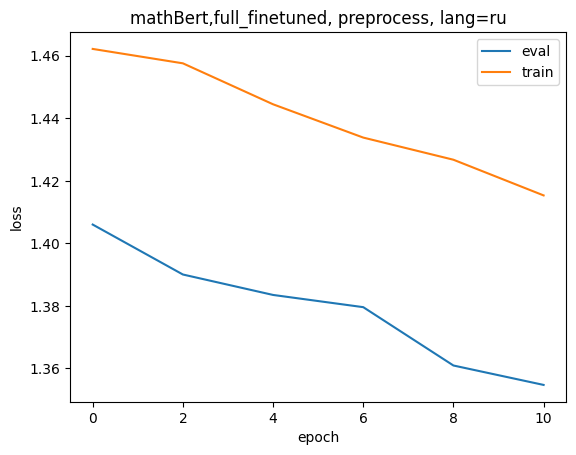

In [ ]:
calc_loss_graph(losses4, 'mathBert,full_finetuned, preprocess, lang=ru')

In [ ]:
'''
без заморозки, с предобработкой, английский язык
'''

df1=df_preprocess(make_simple_preprocess = True, translate_to_en = True)

train_loader, eval_loader=final_dataset(df1, tokenizer_mathBert)

mathBert_full_finetuned,losses5 = train_transformer(mathBert,
                                                    train_loader,eval_loader,
                                                    freeze_backbone=False,
                                                    num_epochs=12)

  0%|          | 0/12 [00:00<?, ?it/s]

epoch : 0 loss train: 1.495870539870287 eval loss: 1.4530509911021408


 17%|█▋        | 2/12 [01:43<08:24, 50.47s/it]

epoch : 2 loss train: 1.423418674135455 eval loss: 1.4141375763075692


 33%|███▎      | 4/12 [03:25<06:42, 50.27s/it]

epoch : 4 loss train: 1.3752919685655307 eval loss: 1.3857730517582016


 50%|█████     | 6/12 [05:07<05:01, 50.26s/it]

epoch : 6 loss train: 1.3361506042085163 eval loss: 1.3403205141729237


 67%|██████▋   | 8/12 [06:50<03:20, 50.24s/it]

epoch : 8 loss train: 1.3002413400096597 eval loss: 1.2981537203399502


 83%|████████▎ | 10/12 [08:32<01:40, 50.24s/it]

epoch : 10 loss train: 1.2654663762898024 eval loss: 1.2535335944623363


100%|██████████| 12/12 [10:14<00:00, 51.23s/it]


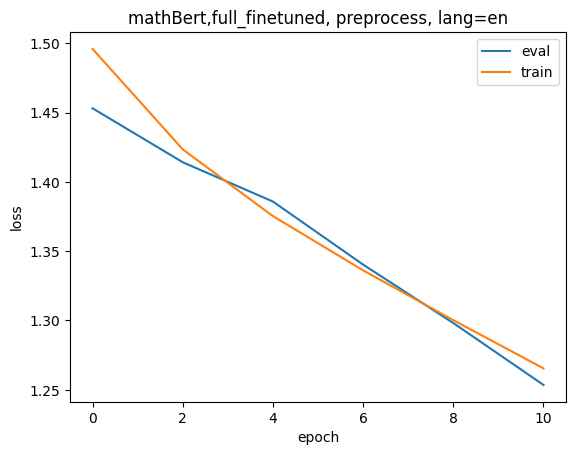

In [ ]:
calc_loss_graph(losses5, 'mathBert,full_finetuned, preprocess, lang=en')

In [ ]:
def preprocess_text(text):
    nums_filtered_text = re.sub('[\r\n]', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in string.punctuation]
    )

    return punct_filtered_text

In [ ]:
'''
функция  отрисовки карт внимания первого слоя для моделей чтобы понять, на какие части текста модель обращает внимание при классификации
'''
def draw_layer_attention_maps(text, model, tokenizer, num_attention_layer=0, num_attention_head=0):
    with torch.no_grad():
        inputs = tokenizer(preprocess_text(text), return_tensors='pt')
        attention_output = model.backbone(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))['attentions'][num_attention_layer]
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        attention_weights = attention_output[0][num_attention_head].cpu().numpy()
        plt.figure(figsize=(10,10))
        fig = sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, square=True)
    return fig

In [ ]:

'''
подготовка данных для обучения transformer-модели
'''

train_df , eval_df = train_test_split(df1, test_size=0.2, shuffle=True)
#  Создание mapping'а классов
    # Если темы: ["алгебра", "геометрия", "арифметика"]
    # Получится: {"алгебра": 0, "геометрия": 1, "арифметика": 2}
name_index = {name : i for (i, name) in enumerate(set(df1['Тема']))}
number_classes = len(name_index) # общее количество уникальных классов

train_data = translation(train_df)
eval_data = translation(eval_df)

# Создание PyTorch Dataset объектов
train_dataset = MyDataset(train_data[0], train_data[1], tokenizer_rubert)
eval_dataset = MyDataset(eval_data[0], eval_data[1], tokenizer_rubert)

# Создание DataLoader для батчевой загрузки
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader  = DataLoader(eval_dataset, batch_size=16, shuffle=True)

In [ ]:
'''
инференс для моделей ДО обучения (замороженная модель) на 2-3 текстах из датасета.
Смотрим на головы Attention первого слоя в каждой модели на выбранных текстах (отрисовывали их отдельно).
'''

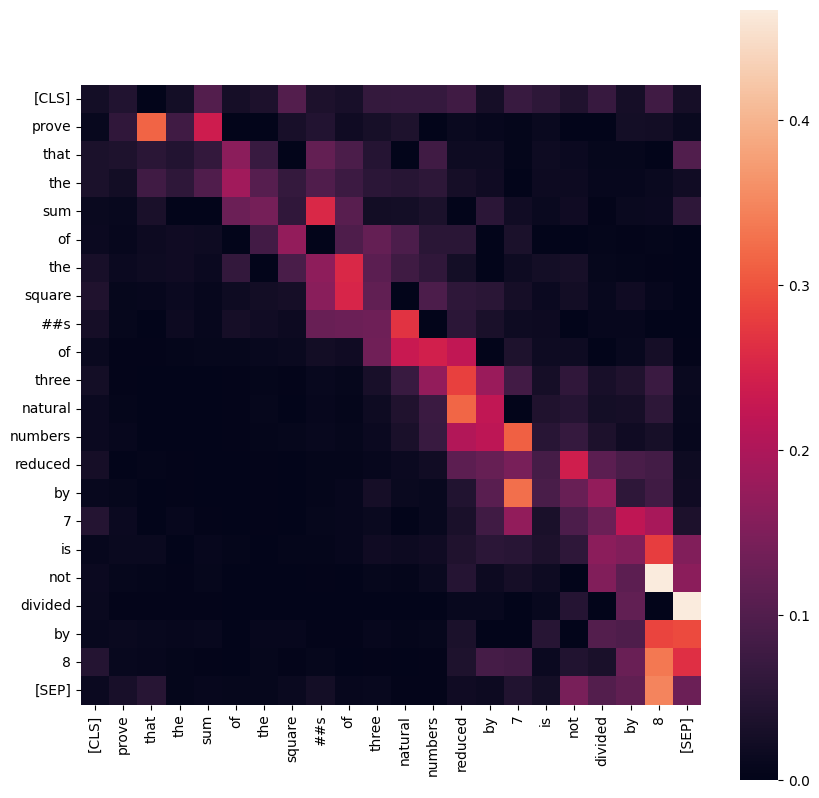

In [ ]:
fig = draw_layer_attention_maps(next(iter(train_dataset))['text'],
                                rubert_freezed,
                                tokenizer_rubert,
                                0, 7); # голова 7
plt.show()

(голова 7, до обучения):

- Диагональная структура: Сильная концентрация внимания на диагонали

- Локальное внимание: Токены фокусируются на ближайших соседях

- Числовые токены: Яркие области вокруг "7", "8" и математических символов

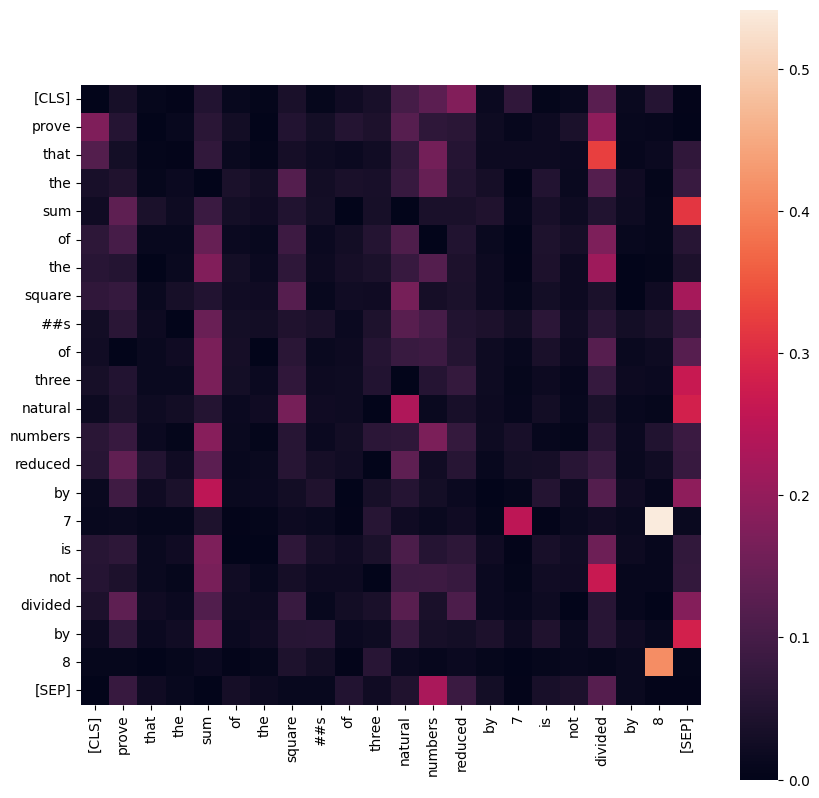

In [ ]:
fig = draw_layer_attention_maps(next(iter(train_dataset))['text'],
                                rubert_freezed,
                                tokenizer_rubert,
                                0, 3); # голова 3
plt.show()

 2 (голова 3, до обучения):

- Более рассеянное внимание: Менее четкая диагональная структура
- Глобальные связи: Некоторые токены обращают внимание на отдаленные части
- Разреженная активация: Больше темных областей

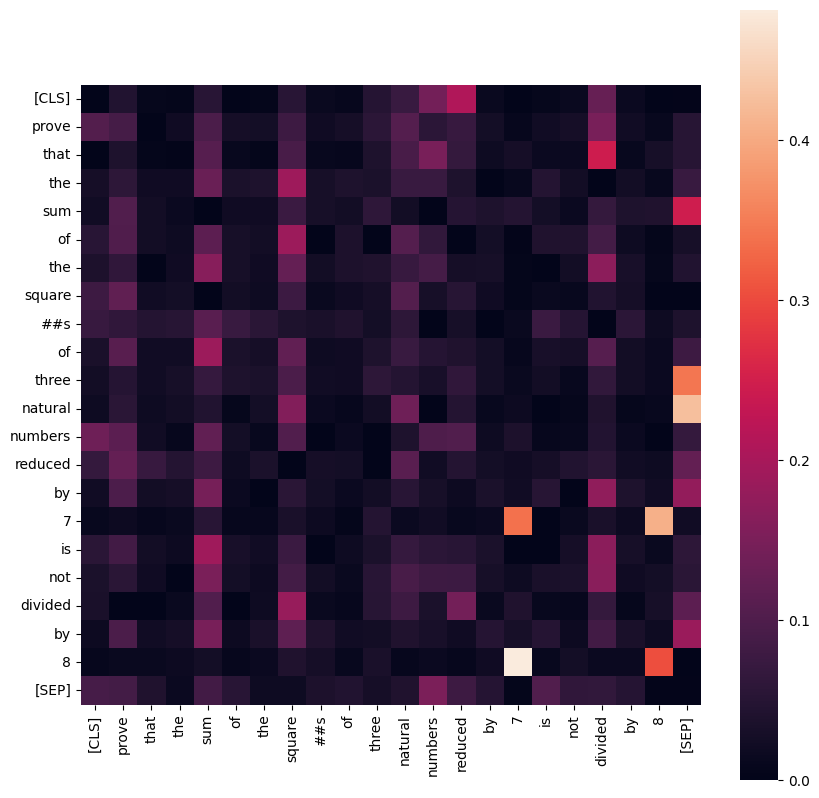

In [ ]:
'''
инференс для всех дообученных моделей на 2-3 текстах из датасета.

Смотрим на головы Attention первого слоя в каждой модели на выбранных текстах (отрисовывали их отдельно).

'''

fig = draw_layer_attention_maps(next(iter(train_dataset))['text'],
                                rubert_full_finetuned_prepr,
                                tokenizer_rubert,
                                0, 3); # голова 3
plt.show()

голова 3, после fine-tuning:

- Структурированные паттерны: Более организованная структура внимания
- Специализация: Четкие блоки активации для разных частей текста
- Математическая фокусировка: Усиленное внимание на ключевых математических терминах

#Датасет

По-видимому, после парсинга данных датасет содержит лишнюю информацию, такую как HTML-разметку сайта, или наоборот недостаточную информацию, кроме того, один и тот же объект может принадлежать нескольким категориям.

Предобработка критически важна.

Предложен вариант очистки датасета (активируется оператором make_simple_preprocess=True функции df_preprocess) - удаление HTML-артефактов и фильтрация коротких текстов, с которым модели отрабатывают лучше.


## Стратегии обучения
Full fine-tuning превосходит заморозку backbone, поскольку позволяет адаптировать все слои к математическому домену

#Модели MathBert, RuBert

Эффект fine-tuning на attention паттерны:

1. Специализация голов внимания: После обучения головы развивают более специфичные паттерны для математических задач
2. Структурная организация: Fine-tuned модель показывает более четкую блочную структуру внимания
3. Фокус на релевантных токенах: Обученная модель лучше выделяет математически значимые элементы

Замораживание моделей оказалось непродуктивным, поскольку препятствовало обучению на основе данных, специфичных для данной области, в то время как их размораживание привело к улучшению производительности и созданию более глубоких карт внимания.
Модель MathBert обучена на английских текстах, поэтому датафрейм был переведен с русского языка на английский с помощью Helsinki-NLP/opus-mt-ru-en. Разумеется, RuBert, обученная на английском корпусе слов, показала результат лучший, чем на русском корпусе. Однако по сравнению с RuBert MathBert, даже обученная на английском датасете, показала несколько худшие результаты. Это может быть связано с некоторой потерей данных при переводе, а также с тем,что несбалансированный по классам датасет перегружен задачам, которые не являются строго вычислительными.

